<a href="https://colab.research.google.com/github/AstridZhao/Spring2023DeepLearning/blob/main/astridZhao_A6_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlretrieve
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import re, cgi
import pandas as pd  

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [ ]:
url_book1="https://www.gutenberg.org/cache/epub/1513/pg1513.txt"
urlretrieve(url_book1, 'book.txt')
text1 = open("book.txt", encoding='utf-8').read().lower()

url_book2="https://www.gutenberg.org/cache/epub/1342/pg1342.txt"
urlretrieve(url_book2, 'book.txt')
text2 = open("book.txt", encoding='utf-8').read().lower()

dataset = {'book':['Romeo and Juliet','Pride and prejudice'],'number of characters': [len(text1), len(text2)]}

df= pd.DataFrame(dataset)   

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

In [ ]:
print('Number of characters in the first text ("Romeo and Juliet"):', len(text1))
print('Number of characters in the second text ("Pride and prejudice"):', len(text2))

Number of characters in the first text ("Romeo and Juliet"): 161697
Number of characters in the second text ("Pride and prejudice"): 748079


In [ ]:
# print the dataset
print(df)  

                  book  number of characters
0     Romeo and Juliet                161697
1  Pride and prejudice                748079


Text(0.5, 0, '')

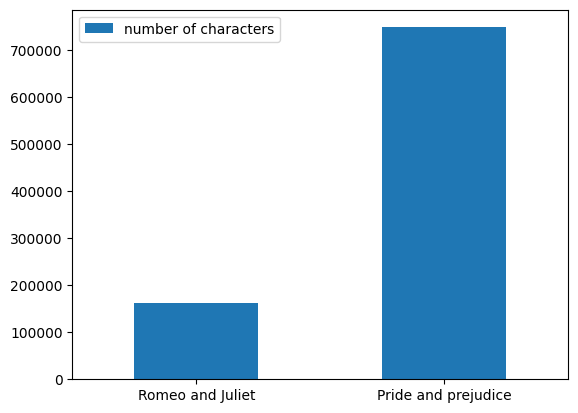

In [ ]:
df.plot(x="book", y = "number of characters",kind='bar',rot=0)
plt.xlabel("")

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [ ]:
# Load the data and convert the characters into one-hot encodings
unique_chars_1 = sorted(list(set(text1)))
print('Unique characters of the book1:', len(unique_chars_1))
unique_chars_2 = sorted(list(set(text2)))
print('Unique characters of the book1:', len(unique_chars_2))

Unique characters of the book1: 63
Unique characters of the book1: 72


In [ ]:
# load the data into a 3D NumPy array
char_indices_1 = dict((c, i) for i, c in enumerate(unique_chars_1))
indices_char_1 = dict((i, c) for i, c in enumerate(unique_chars_1))
print ("Indices to char dictionary of book1:", indices_char_1)

char_indices_2 = dict((c, i) for i, c in enumerate(unique_chars_2))
indices_char_2 = dict((i, c) for i, c in enumerate(unique_chars_2))
print ("Indices to char dictionary of book2:", indices_char_2)

# combine the data together 
indice_char = (indices_char_1 | indices_char_2 )
print("Indices to char dictionary: ",indice_char)

char_indices = (char_indices_1 | char_indices_2 )
# print("Char to Indices dictionary: ",char_indices)



Indices to char dictionary of book1: {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '#', 5: '$', 6: '%', 7: '&', 8: "'", 9: '(', 10: ')', 11: '*', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '?', 29: '[', 30: ']', 31: '_', 32: 'a', 33: 'b', 34: 'c', 35: 'd', 36: 'e', 37: 'f', 38: 'g', 39: 'h', 40: 'i', 41: 'j', 42: 'k', 43: 'l', 44: 'm', 45: 'n', 46: 'o', 47: 'p', 48: 'q', 49: 'r', 50: 's', 51: 't', 52: 'u', 53: 'v', 54: 'w', 55: 'x', 56: 'y', 57: 'z', 58: 'æ', 59: '—', 60: '‘', 61: '’', 62: '\ufeff'}
Indices to char dictionary of book2: {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '#', 5: '$', 6: '%', 7: '&', 8: "'", 9: '(', 10: ')', 11: '*', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '?', 29: '[', 30: ']', 31: '^', 32: '_', 33: 'a', 34: 'b', 35: 'c', 36: 'd', 37: 'e', 38: 'f', 39: 'g', 40: 'h', 4

In [ ]:
# The sequences should be cut out from the complete dataset by sliding window. 
# You should add 0 and 1 labels to the sequences, according to the author.
sequence_length = 60
step = 50

sequence = []
label1 = []
label2 = []
label = [] 

for i in range(0, len(text1) - sequence_length + 1, step):
    sequence.append(text1[i:i+sequence_length])
    label1.append(0)  # text1

for i in range(0, len(text2) - sequence_length + 1, step):
    sequence.append(text2[i:i+sequence_length])
    label2.append(1)  # text2

label = label1 + label2

In [ ]:
#testing
print('Number of training samples:', len(label)) 
print('Number of sequences:', len(sequence))

Number of training samples: 18194
Number of sequences: 18194


In [ ]:
#(batch, sequence_length, alphabet_length)
batch = len(label)

alphabet_length = len(char_indices) # alphabet_length equals to the number of unique characters

# Creating NumPy arrays with the correct shapes:
X = np.zeros((batch,sequence_length,alphabet_length), dtype=float)
Y = np.zeros((batch,1), dtype= float)

In [ ]:
# Introducing one-hot encodings to the NumPy arrays:
for i, sentence in enumerate(sequence):
    for t, char in enumerate(sentence): 
      X[i,t,char_indices[char]] = 1

for i, sentence in enumerate(sequence):
    Y[i,0] = label[i]

print ("Shape of the input data:", X.shape)
print ("Shape of the target data:", Y.shape)

Shape of the input data: (18194, 60, 74)
Shape of the target data: (18194, 1)


## Data splitting
Split the data into train, validate and test sets. Make 

In [ ]:
valid_split = 0.2
test_split  = 0.1

num = len(label1)
num2 = len(label2)

# change v_point 
v_point_1 = int((num*(1-valid_split - test_split)))
t_point_1 = int((num*(1-test_split)))

v_point_2 = int((num2*(1-valid_split - test_split)))
t_point_2 = int((num2*(1-test_split)))

X_1 = X[:num]
X_2 = X[num:]

X_train_1 = X_1[:v_point_1] 
X_train_2 = X_2[:v_point_2] 

X_valid_1 = X_1[v_point_1:t_point_1]
X_valid_2 = X_2[v_point_2:t_point_2]

X_test_1 = X_1[t_point_1:]
X_test_2 = X_2[t_point_2:]

Y_1 = Y[:num] 
Y_2 = Y[num:]

Y_train_1 = Y_1[:v_point_1] 
Y_train_2 = Y_2[:v_point_2] 

Y_valid_1 = Y_1[v_point_1:t_point_1]
Y_valid_2 = Y_2[v_point_2:t_point_2]

Y_test_1 = Y_1[t_point_1:]
Y_test_2 = Y_2[t_point_2:]

X_train = np.concatenate((X_train_1,X_train_2))
X_valid = np.concatenate((X_valid_1,X_valid_2))
X_test = np.concatenate((X_test_1,X_test_2))

Y_train = np.concatenate((Y_train_1,Y_train_2))
Y_valid = np.concatenate((Y_valid_1,Y_valid_2))
Y_test = np.concatenate((Y_test_1,Y_test_2))

In [ ]:
print ("Shape of the input data:", X_train.shape)
print ("Shape of the target data:", Y_train.shape)

Shape of the input data: (12735, 60, 74)
Shape of the target data: (12735, 1)


## Model definition
Define an LSTM (or a 1D CNN) for the task. Compile the model with the correct loss function.

In [ ]:
# model = Sequential()
# model.add(LSTM(128, input_shape=(X_train.shape[-2], X_train.shape[-1])))
# model.add(Dense(alphabet_length))
# model.add(Activation('sigmoid'))

# # model.add(Flatten())
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, Reshape

nb_filter       = 32   # number of filter/kernels in the convolutional layers
filter_length   = 3  # length of the filter/kernel in the convolutional layers
window_size     = X_train.shape[1] # the window size defined by the dataset
nb_features     = X_train.shape[2] # the number of features of the input data
nb_outputs      = Y_train.shape[1]

model = Sequential()
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1] ,X_train.shape[2])))
model.add(MaxPooling1D())
model.add(Dropout(0.3))
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling1D())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(nb_outputs, activation='sigmoid'))

In [ ]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 32)            7136      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 29, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 32)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 13, 32)            0

In [ ]:
print('Input: ', model.input)
print('Output: ', model.output)

Input:  KerasTensor(type_spec=TensorSpec(shape=(None, 60, 74), dtype=tf.float32, name='conv1d_input'), name='conv1d_input', description="created by layer 'conv1d_input'")
Output:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")


## Model training
Train the model and apply early stopping.

In [ ]:
# Early Stopping
es = EarlyStopping(patience=5, 
                  restore_best_weights=True,
                  monitor='val_accuracy')

In [ ]:
model.fit(X_train, Y_train, 
          epochs=50, 
          validation_data=(X_valid,Y_valid),
          callbacks=[es],
          verbose=2)

Epoch 1/50
398/398 - 5s - loss: 0.3541 - accuracy: 0.8505 - val_loss: 0.2624 - val_accuracy: 0.8980 - 5s/epoch - 12ms/step
Epoch 2/50
398/398 - 4s - loss: 0.2603 - accuracy: 0.8960 - val_loss: 0.4578 - val_accuracy: 0.7952 - 4s/epoch - 10ms/step
Epoch 3/50
398/398 - 4s - loss: 0.2419 - accuracy: 0.9043 - val_loss: 0.2627 - val_accuracy: 0.8911 - 4s/epoch - 10ms/step
Epoch 4/50
398/398 - 3s - loss: 0.2269 - accuracy: 0.9141 - val_loss: 0.3003 - val_accuracy: 0.8826 - 3s/epoch - 8ms/step
Epoch 5/50
398/398 - 3s - loss: 0.2212 - accuracy: 0.9165 - val_loss: 0.3408 - val_accuracy: 0.8623 - 3s/epoch - 8ms/step
Epoch 6/50
398/398 - 4s - loss: 0.2109 - accuracy: 0.9199 - val_loss: 0.3499 - val_accuracy: 0.8692 - 4s/epoch - 11ms/step


## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [ ]:
eval = model.evaluate(X_test,Y_test)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

57/57 [==============================] - 0s 3ms/step - loss: 0.5881 - accuracy: 0.7935
Test loss: 0.5881094932556152
Test accuracy: 0.7935200333595276


## Confusion matrix
Calculate and display the confusion matrix.

In [ ]:
Y_test.shape

(1821, 1)

In [ ]:
Y_test

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
preds = model.predict(X_test)
print(classification_report(np.round_(Y_test),np.round_(preds)))

57/57 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.23      0.07      0.11       324
         1.0       0.83      0.95      0.88      1497

    accuracy                           0.79      1821
   macro avg       0.53      0.51      0.50      1821
weighted avg       0.72      0.79      0.75      1821



<Axes: >

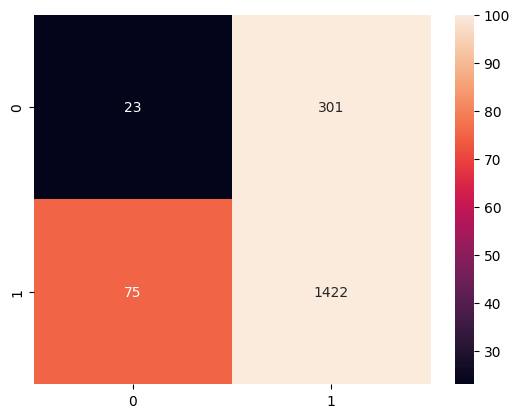

In [30]:
conf=confusion_matrix(np.round_(Y_test),np.round_(preds))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)